In [1]:
import importlib
import tempfile
import os
import numpy as np
import matplotlib.pyplot as plt
from ics.hxutils import hxramp
from h4rg_analysis import io, ramputils
import makefigures_noise

In [2]:
def scaled_imshow ( im, ax=None, beta=0.01, colorbar=True ):
    if ax is None:
        ax = plt.subplot(111)
    vmin, vmax = np.nanquantile ( im, [beta, 1. - beta] )
    imout = ax.imshow ( im, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar ( imout, ax=ax )
    return ax

In [3]:
bestbaselines = open ('../data/paths/best_ever_baseline_darks_8_21_2022.txt', 'r').read().splitlines()[1:]
rampids = makefigures_noise.load_rampids ()

In [4]:
rampA = hxramp.HxRamp(io.jhu2tiger(bestbaselines[0]))
rampB = hxramp.HxRamp(io.jhu2tiger(bestbaselines[1]))

In [5]:
nbins = 5
step = rampA.ncols // nbins
sl_indices = np.concatenate ( [np.arange(0, rampA.ncols, step)[:-1], [rampA.ncols+1]] )
slices = [ slice(sl_indices[idx], sl_indices[idx+1]) for idx in range(sl_indices.size-1) ]

In [7]:
tfileA=tempfile.NamedTemporaryFile(dir='./')
cubeA,_ = io.corrStack_memmap ( rampA, filename=tfileA, 
                               slicey=slices[1], slicex=slices[1] )
tfileB=tempfile.NamedTdemporaryFile(dir='./')
cubeB,_ = io.corrStack_memmap ( rampB, filename=tfileB, 
                               slicey=slices[1], slicex=slices[1] )
print(tfileA,tfileB)

<tempfile._TemporaryFileWrapper object at 0x2b50b30ddd10> <tempfile._TemporaryFileWrapper object at 0x2b51ef7e3910>


In [8]:
ypix,xpix = 200,200

In [536]:
importlib.reload(ramputils)

<module 'h4rg_analysis.ramputils' from '/tigress/kadofong/machine_harmony/repos_post0903/h4rg_analysis/ramputils.py'>

In [580]:
fy[[1]].shape

(1, 50, 50)

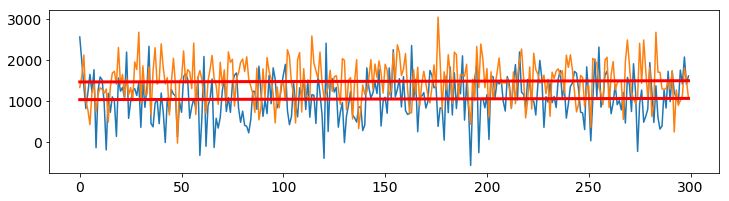

In [588]:
findices = np.arange(300).reshape(300,1,1,)
reset = 1005.
#fy = np.ones([1,50,50])*reset #
fy = np.random.normal(1000., 200., [2,50,50])
frate = .1
noise = 500.
fake_cubeA= findices*frate + fy[[0]] + np.random.normal(0., noise, [findices.size, fy.shape[1], fy.shape[2]])
fake_cubeB= findices*frate + fy[[1]] + np.random.normal(0., noise, [findices.size, fy.shape[1], fy.shape[2]])

xs = np.logspace(np.log10(5.),np.log10(299),20).astype(int)
rnarr = np.zeros([5,xs.shape[0]])
for idx, read_idx in enumerate(xs):
    ca = fake_cubeA[:(read_idx+1)].astype(float)
    cb = fake_cubeB[:(read_idx+1)].astype(float)
    _,rhatA,rhatA_se = ramputils.utr_expectedflux ( ca )
    _,rhatB,rhatB_se = ramputils.utr_expectedflux ( cb )
    detarea = 2.*fake_cubeA.shape[1]*fake_cubeA.shape[2]
    
    sqdiff = (rhatA[0] - rhatB[0])**2
    rate_noise = np.sqrt( np.sum(sqdiff) / detarea )
    
    sq_sigdiff = (( ca - rhatA[1] ) - ( cb - rhatB[1] ))**2
    signal_noise = np.sqrt( np.sum(sq_sigdiff) / detarea )
    
    rnarr[0,idx] = rate_noise
    rnarr[1,idx] = signal_noise
    #rnarr[1,idx] = np.median ( rhatA_se[0] ) 
    rnarr[2,idx] = np.mean ( rhatB_se[0] ) 
    
    
    ypred = rhatA[0]*read_idx + rhatA[1]
    ytrue = frate*read_idx + fy[0]
    rnarr[3, idx] = np.std ( rhatA[0] - frate )
    rnarr[4, idx] = np.std ( ypred - ytrue )/np.sqrt(read_idx)

diff = (fake_cubeA.astype(float) - rhatA[1]) - (fake_cubeB.astype(float) - rhatB[1])
rmse = np.std(diff)

fig = plt.figure (figsize=(12,3))
plt.plot ( fake_cubeA[:,1,1])
plt.plot ( fake_cubeB[:,1,1])
plt.plot ( findices.flatten(), findices.flatten()*frate + fy[0, 1,1], color='r', lw=3)
plt.plot ( findices.flatten(), findices.flatten()*frate + fy[1, 1,1], color='r', lw=3)

-1.4418611816703135
0.45984237955679563
-0.9143934647589788


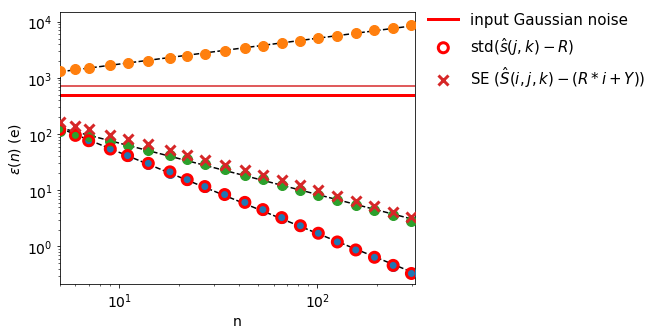

In [589]:
fig, axarr = plt.subplots(1,2, figsize=(14,5))
ax = axarr[0]
fig.delaxes(axarr[1])
kwargs = {'s':100, 'zorder':10}

labels = [
    r'$\epsilon^2_{er}=\frac{\sum_k^K\sum_l^L ( \hat s_1(k,l) - \hat s_0(k,l) )^2}{2KL}$',
    r'$\epsilon^2_{ms}=\frac{\sum_k^K\sum_l^L ( \tilde S_1(k,l) - \tilde S_0(k,l))^2}{2KL}$',
    r'$\epsilon^2_{se}=\langle \frac{\sum_i^N (S_0(i,k,l) - \hat S_0(i,k,l))^2}{N-2} \frac{\sum_i^N i^2}{\sum_i^N(i-\bar i)}\rangle_{k,l}$'
]

for ix in range(3):
    ofit = np.polyfit ( np.log10(xs), np.log10(rnarr[ix]), 1)
    print(ofit[0])
    ax.plot (xs, 10.**np.poly1d(ofit)(np.log10(xs)), color='k', ls='--', )
    ax.scatter ( xs, rnarr[ix], **kwargs )
    
#plt.scatter ( xs, rnarr[0]*trat )
ax.scatter ( xs, rnarr[3], s=10**2, edgecolor='r', facecolor="None", lw=3, zorder=10, 
           label = r'std($\hat s(j,k) - R$)')
ax.scatter ( xs, rnarr[4], s=10**2, edgecolor='r', marker='x', lw=3, zorder=10,
           label = r'SE ($\hat S(i,j,k) - (R*i + Y))$')

ax.axhline(noise, color='r', lw=3, label='input Gaussian noise')
ax.axhline(rmse, color='tab:red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(5., 310)
ax.set_xlabel (r'n')
ax.set_ylabel (r'$\epsilon(n)$ (e)')
ax.legend ( bbox_to_anchor=(1.0, .05, .5,1.), fontsize=15, frameon=False)
#plt.tight_layout ()
#plt.savefig('../figures/epsilon.png')

In [591]:
xs = np.logspace(1,np.log10(299),10).astype(int)
rnarr = np.zeros([3,xs.shape[0]])
for idx, read_idx in enumerate(xs):
    ca = cubeA[:(read_idx+1)].astype(float)
    cb = cubeB[:(read_idx+1)].astype(float)
    _,rhatA,rhatA_se = ramputils.utr_expectedflux ( ca )
    _,rhatB,rhatB_se = ramputils.utr_expectedflux ( cb )
    detarea = 2.*cubeA.shape[1]*cubeA.shape[2]
    
    sqdiff = (rhatA[0] - rhatB[0])**2
    rate_noise = makefigures_noise.gain * np.sqrt( np.sum(sqdiff) / detarea )
    
    sq_sigdiff = (( ca - rhatA[1] ) - ( cb - rhatB[1] ))**2
    signal_noise = makefigures_noise.gain * np.sqrt( np.sum(sq_sigdiff) / detarea )
    
    rnarr[0,idx] = rate_noise
    rnarr[1,idx] = signal_noise
    #rnarr[1,idx] = np.median ( rhatA_se[0] ) * makefigures _noise.gain
    rnarr[2,idx] = np.median ( rhatB_se[0] ) * makefigures_noise.gain
# \\ reset-adjusted difference between two reads of the same pixel at the same point in the ramp
diff = (cubeA.astype(float) - rhatA[1]) - (cubeB.astype(float) - rhatB[1])    

In [593]:
beta=0.01
vmin, mid, vmax = np.quantile(diff, [beta,.5,1.-beta])
mask = (diff>vmin)&(diff<=vmax)
rms = np.sqrt(np.sum(diff[mask]**2)/diff[mask].size) * makefigures_noise.gain

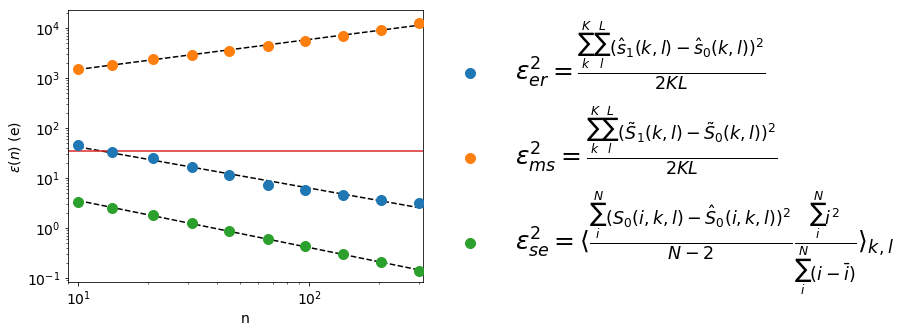

In [594]:
fig, axarr = plt.subplots(1,2, figsize=(14,5))
ax = axarr[0]
fig.delaxes(axarr[1])
kwargs = {'s':100, 'zorder':10}

labels = [
    r'$\epsilon^2_{er}=\frac{\sum_k^K\sum_l^L ( \hat s_1(k,l) - \hat s_0(k,l) )^2}{2KL}$',
    r'$\epsilon^2_{ms}=\frac{\sum_k^K\sum_l^L ( \tilde S_1(k,l) - \tilde S_0(k,l))^2}{2KL}$',
    r'$\epsilon^2_{se}=\langle \frac{\sum_i^N (S_0(i,k,l) - \hat S_0(i,k,l))^2}{N-2} \frac{\sum_i^N i^2}{\sum_i^N(i-\bar i)}\rangle_{k,l}$'
]

for ix in range(3):
    ofit = np.polyfit ( np.log10(xs), np.log10(rnarr[ix]), 1)
    ax.plot (xs, 10.**np.poly1d(ofit)(np.log10(xs)), color='k', ls='--', )
    ax.scatter ( xs, rnarr[ix], label=labels[ix], **kwargs )
#plt.scatter ( xs, rnarr[0]*trat )

ax.axhline(rms, color='tab:red')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(9., 310)
ax.set_xlabel (r'n')
ax.set_ylabel (r'$\epsilon(n)$ (e)')
ax.legend ( bbox_to_anchor=(1.0, .05, 1.,1.), fontsize=25, frameon=False)
#plt.tight_layout ()
#plt.savefig('../figures/epsilon.png')

(array([ 2043.,  2557.,  3182.,  3880.,  4958.,  6169.,  7419.,  9059.,
        10838., 12924., 15252., 17735., 20309., 23009., 26239., 28879.,
        31895., 34354., 37226., 39419., 41675., 43040., 43576., 44592.,
        44678., 44151., 42953., 41644., 39927., 37485., 34934., 32104.,
        29079., 26355., 23444., 20335., 17942., 15300., 13166., 11133.,
         9426.,  7623.,  6328.,  5204.,  4197.,  3327.,  2732.,  2196.,
         1712.]),
 array([-4.63170299e-02, -4.43881010e-02, -4.24591720e-02, -4.05302430e-02,
        -3.86013141e-02, -3.66723851e-02, -3.47434561e-02, -3.28145272e-02,
        -3.08855982e-02, -2.89566692e-02, -2.70277403e-02, -2.50988113e-02,
        -2.31698823e-02, -2.12409534e-02, -1.93120244e-02, -1.73830955e-02,
        -1.54541665e-02, -1.35252375e-02, -1.15963086e-02, -9.66737960e-03,
        -7.73845064e-03, -5.80952167e-03, -3.88059271e-03, -1.95166374e-03,
        -2.27347791e-05,  1.90619419e-03,  3.83512315e-03,  5.76405211e-03,
         7.6929810

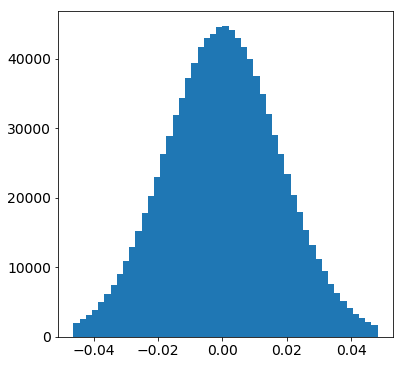

In [600]:
vmin, vmax= np.quantile((rhatA[0] - rhatB[0]).flatten(), [beta, 1.-beta])
plt.hist((rhatA[0] - rhatB[0]).flatten(), bins=np.linspace(vmin, vmax))

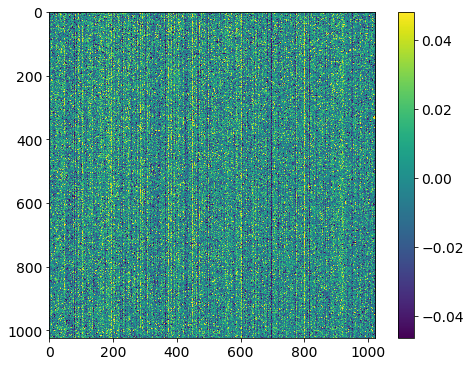

In [596]:
fig = plt.figure(figsize=(8,6))
scaled_imshow(rhatA[0] - rhatB[0])

Text(0.5, 0, 'ramp A - ramp B (ADU)')

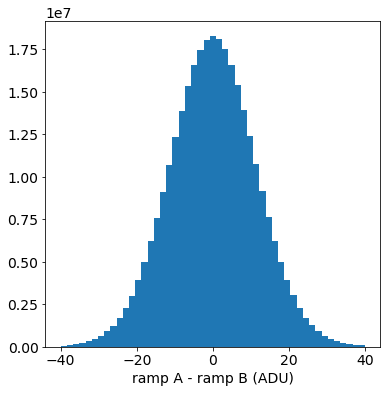

In [273]:
_=plt.hist(diff.flatten(), bins=np.linspace(-40, 40., 50))
plt.xlabel('ramp A - ramp B (ADU)' )

In [288]:
mdiff = np.where(mask, diff, np.NaN)
ramp_rms = np.sqrt(np.nansum(mdiff**2, axis=0) / mask.sum(axis=0) ) * makefigures_noise.gain

/tigress/kadofong/machine_harmony/repos_post0903/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [345]:
cubeA[-1] - cubeA[0]

array([[   12,    22,    21, ...,    39,    29,    14],
       [   38,    26,    16, ...,    41,    25,    22],
       [   28,    19,    27, ...,    17,    44,     8],
       ...,
       [    5,    13,    19, ...,    15,    20,     6],
       [   29,    14,    18, ...,     7,     3, 65533],
       [   13,    17,    12, ...,    25,     1,    18]], dtype=uint16)

In [344]:
rhatA[0]*300

array([[18.91566968, 14.5418958 , 17.13591165, ..., 19.22812058,
        10.16327355, 16.51585823],
       [25.10866198, 14.92464816, 19.90150614, ..., 15.33029562,
         9.75695271, 18.32968957],
       [18.91297614, 15.47884447, 19.59969473, ..., 16.21970326,
        11.10049157, 14.72640345],
       ...,
       [19.56440933, 11.75663846, 14.48694754, ..., 11.52108819,
         7.62205113, 14.50216606],
       [19.33640098,  5.57509371, 15.64880699, ..., 13.19795291,
         9.73648178, 11.36001437],
       [19.57760769,  5.48849633, 16.50562277, ..., 20.86296604,
        10.0735786 , 13.67349779]])

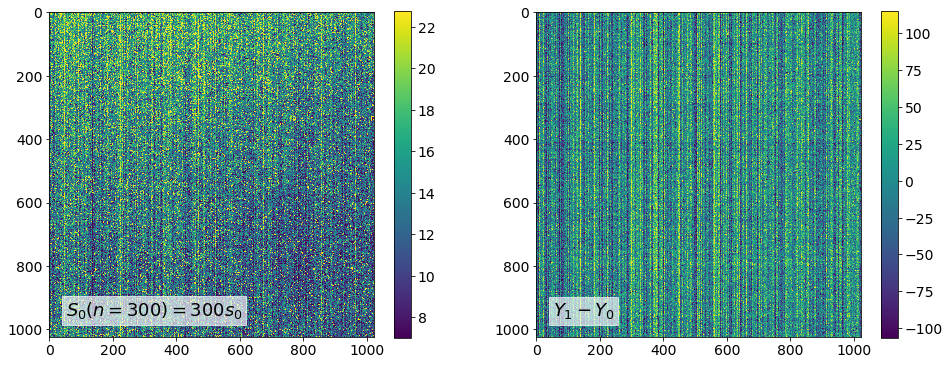

In [341]:
fig, axarr = plt.subplots ( 1,2, figsize=(16,6))
scaled_imshow ( rhatA[0]*300, ax=axarr[0], beta=0.05 )
scaled_imshow ( rhatA[1]-rhatB[1], ax=axarr[1] )
kwargs = {'bbox':{"fc":"w", 'ec':'w', 'alpha':0.65}, 'fontsize':18}
axarr[0].text(0.05, 0.05, r'$S_0(n=300)=300s_0$', ha='left', va='bottom',
              transform=axarr[0].transAxes,
              **kwargs)
axarr[1].text(0.05, 0.05, r'$Y_1-Y_0$', ha='left', va='bottom', 
              transform=axarr[1].transAxes,
              **kwargs)
plt.savefig("../figures/reset.png")

In [174]:
idx = 10
lmask = (diff[idx]>vmin)&(diff[idx]<=vmax)
lrms = np.sqrt(np.sum(diff[idx][lmask]**2)/diff[idx][lmask].size)

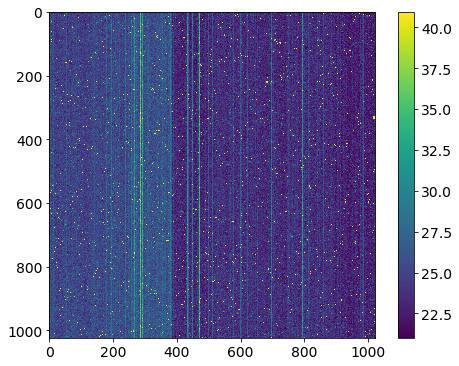

In [144]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
scaled_imshow(noise_along_ramp, ax=ax)

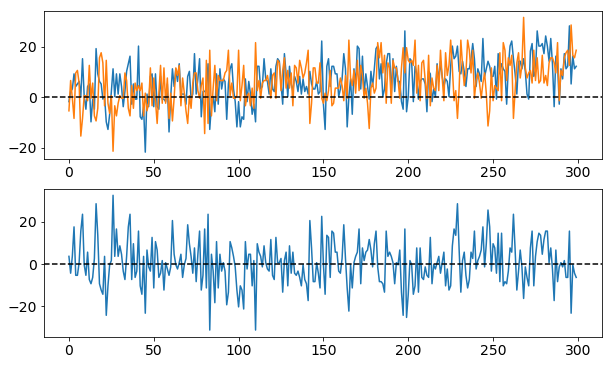

In [98]:
fig, axarr = plt.subplots(2,1,figsize=(10,6))
ax = axarr[0]
ax.plot ( anrm )
ax.plot ( bnr m )
ax.axhline(0., color='k', ls='--')
ax = axarr[1]
ax.plot( anrm-bnrm )
ax.axhline(0., color='k', ls='--')

In [84]:
anrm = cubeA[:,ypix,xpix].astype(float) - rhatA[1][ypix,xpix]
bnrm = cubeB[:,ypix,xpix].astype(float) - rhatB[1][ypix,xpix]

Text(0, 0.5, 'noise on total signal (e)')

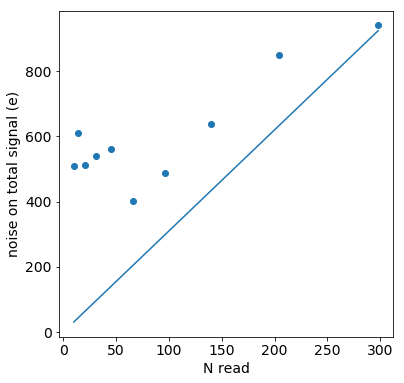

In [82]:
plt.scatter ( xs, noise )
plt.plot (xs, rate_noise*xs)
plt.xlabel ( 'N read')
plt.ylabel ( 'noise on total signal (e)' )

In [109]:
rate_noise =  makefigures_noise.gain * np.sqrt(np.sum(rhatA[0] - rhatB[0])**2 / (2.*rampA.ncols*rampA.nrows)) 

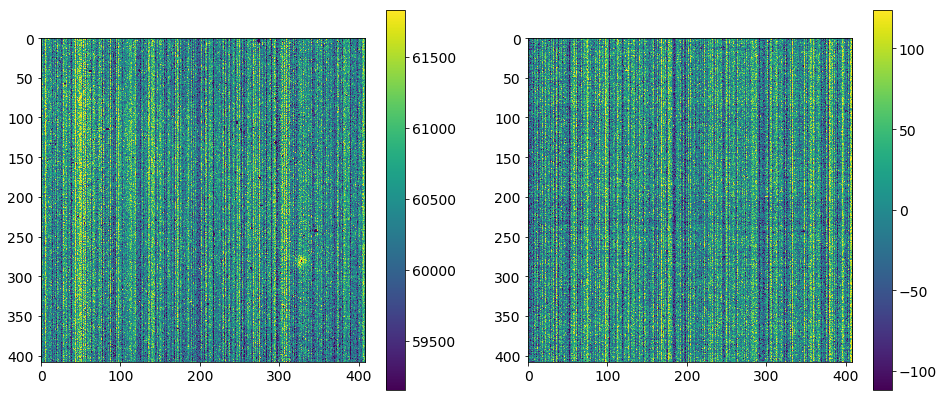

In [124]:
fig, axarr = plt.subplots ( 1,2,figsize=(16,7))
scaled_imshow ( cubeA[0], axarr[0] )
scaled_imshow ( cubeA[0].astype(float) - cubeB[0].astype(float), axarr[1] )


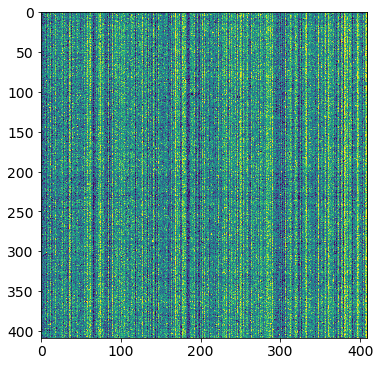

In [87]:
vmin,vmax = np.quantile(ndiff, [beta, 1.-beta])
plt.imshow(ndiff, vmin=vmin,vmax=vmax)

(array([  716.,   893.,  1398.,  2002.,  2699.,  3571.,  4681.,  5751.,
         7220.,  8127.,  9450., 10583., 11448., 11682., 11872., 11453.,
        10743.,  9935.,  8753.,  7371.,  6045.,  4813.,  3847.,  2903.,
         2040.,  1559.,  1092.,   759.,   529.]),
 array([-0.04578349, -0.04255356, -0.03932364, -0.03609372, -0.0328638 ,
        -0.02963387, -0.02640395, -0.02317403, -0.01994411, -0.01671418,
        -0.01348426, -0.01025434, -0.00702442, -0.00379449, -0.00056457,
         0.00266535,  0.00589527,  0.0091252 ,  0.01235512,  0.01558504,
         0.01881496,  0.02204489,  0.02527481,  0.02850473,  0.03173465,
         0.03496458,  0.0381945 ,  0.04142442,  0.04465434,  0.04788427]),
 <a list of 29 Patch objects>)

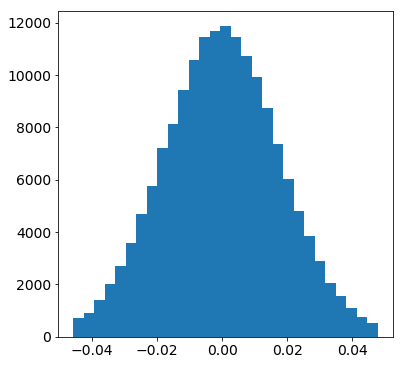

In [70]:
plt.hist ( (rhatA[0] - rhatB[0]).flatten(), bins=np.linspace(vmin,vmax,30))

113.12426781273214